# Short example

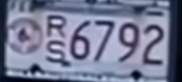

RS6792


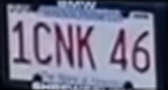

NK46


In [12]:
from app.video_processor import process_video
from pathlib import Path
from IPython.display import Image as Img, display
from PIL import Image
import cv2

numbers = process_video(Path('./data/BMW_320I_2018_black_1.MOV'))
for nomber_text, plate_image in numbers:
    display(Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)))
    print(nomber_text)

# Details

In [1]:
from app.models.plate_detection_model import PlateDetectionModel
from app.models.text_detection_model import TextDetectionModel
from app.perspective_transform import PerspectiveTransform
from app.utils.coordinat_utils import letterbox
from app.utils.image_utils import add_boxes_to_image, cut_boxes_from_image, wrap_perspective, cut_box
import cv2
from IPython.display import clear_output, Image as Img, display, HTML
from PIL import Image
from app.plate_recognition import select_best, stack_images_ECC, letter_image_preprocessing
import time
import numpy as np
import pytesseract
from pathlib import Path

In [2]:
detection_model = PlateDetectionModel()

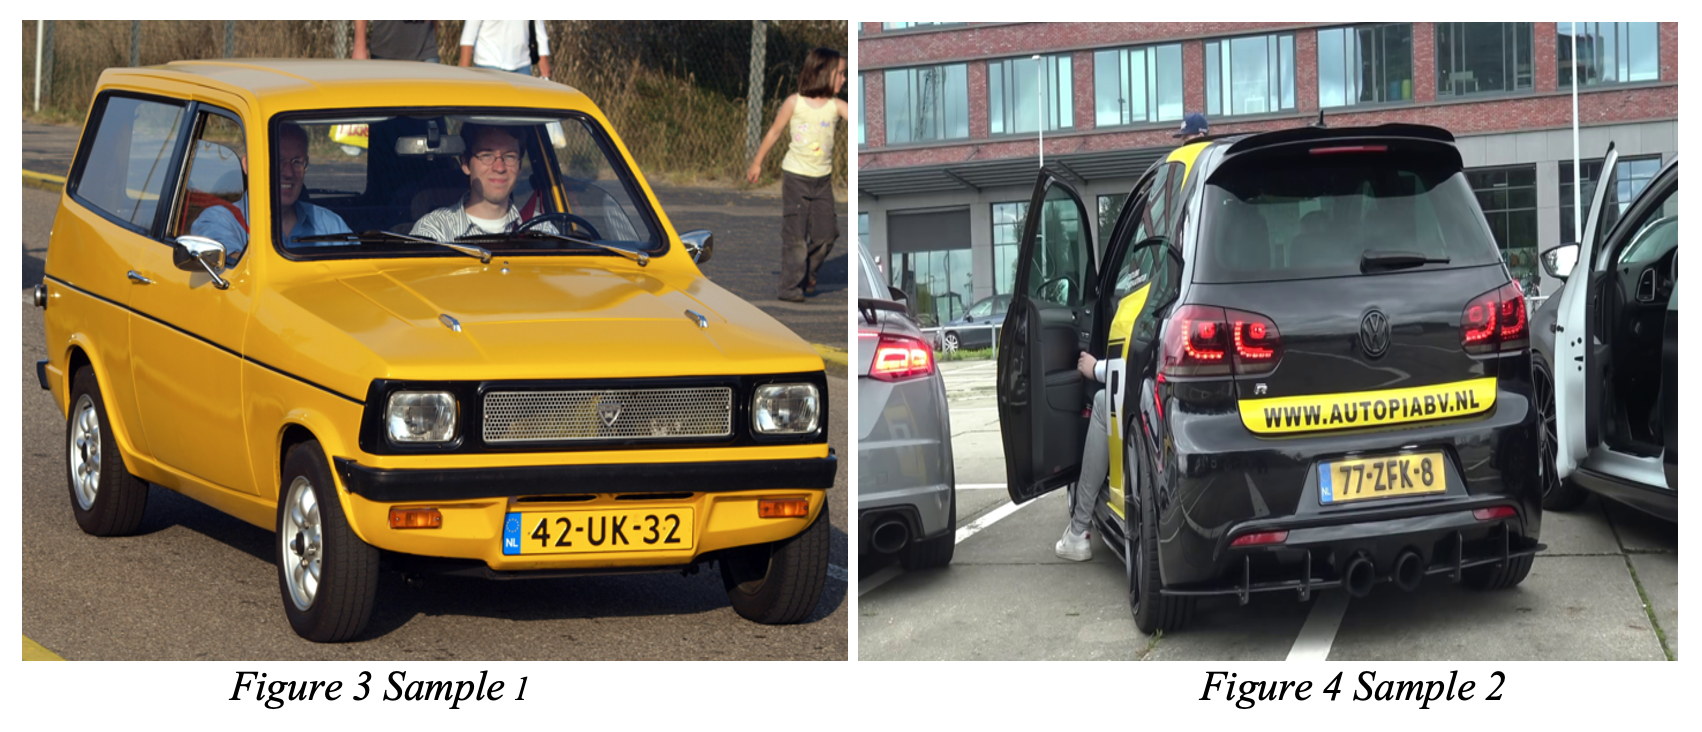

(0.37602820211515864, 0.37602820211515864) (0.0, 22.5)
orig_image.shape (732, 1702, 3)
image.shape (320, 640, 3)


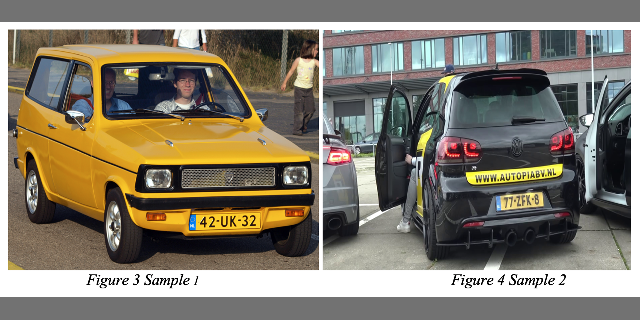

In [3]:
orig_image = cv2.imread("./data/Notebook5.png")
orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(orig_image))
image, ratio, (dw, dh) = letterbox(orig_image, stride=64, auto=True)
print(ratio, (dw, dh))
print("orig_image.shape", orig_image.shape)
print("image.shape", image.shape)
display(Image.fromarray(image))

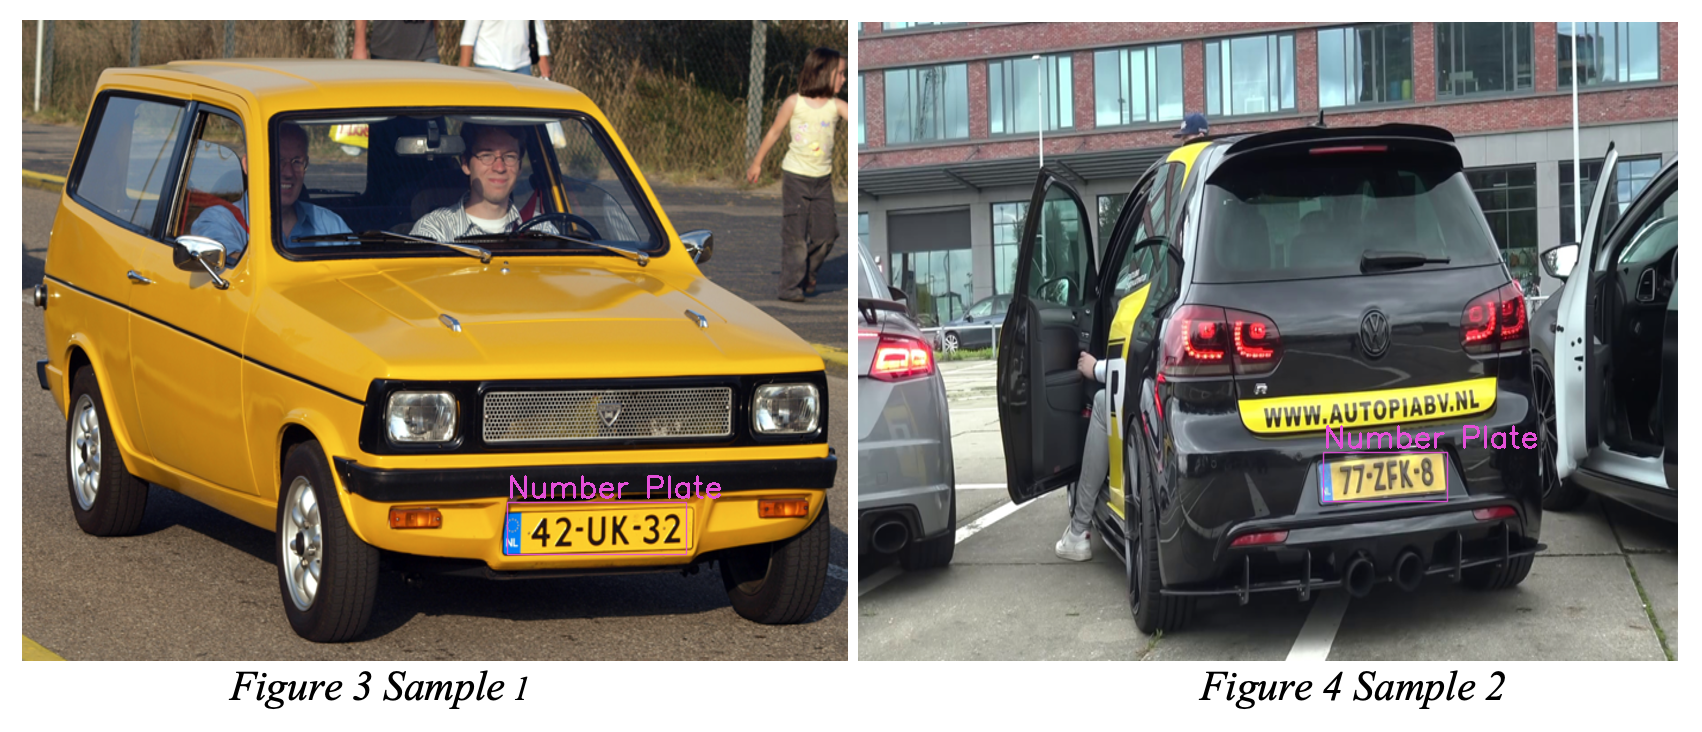

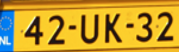

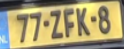

In [4]:
boxes = detection_model.find_boxes_on_image(orig_image)
image_with_boxes = add_boxes_to_image(orig_image, boxes)
display(Image.fromarray(image_with_boxes))

plate_images = cut_boxes_from_image(orig_image, boxes)
for plate_image in plate_images:
    display(Image.fromarray(plate_image))

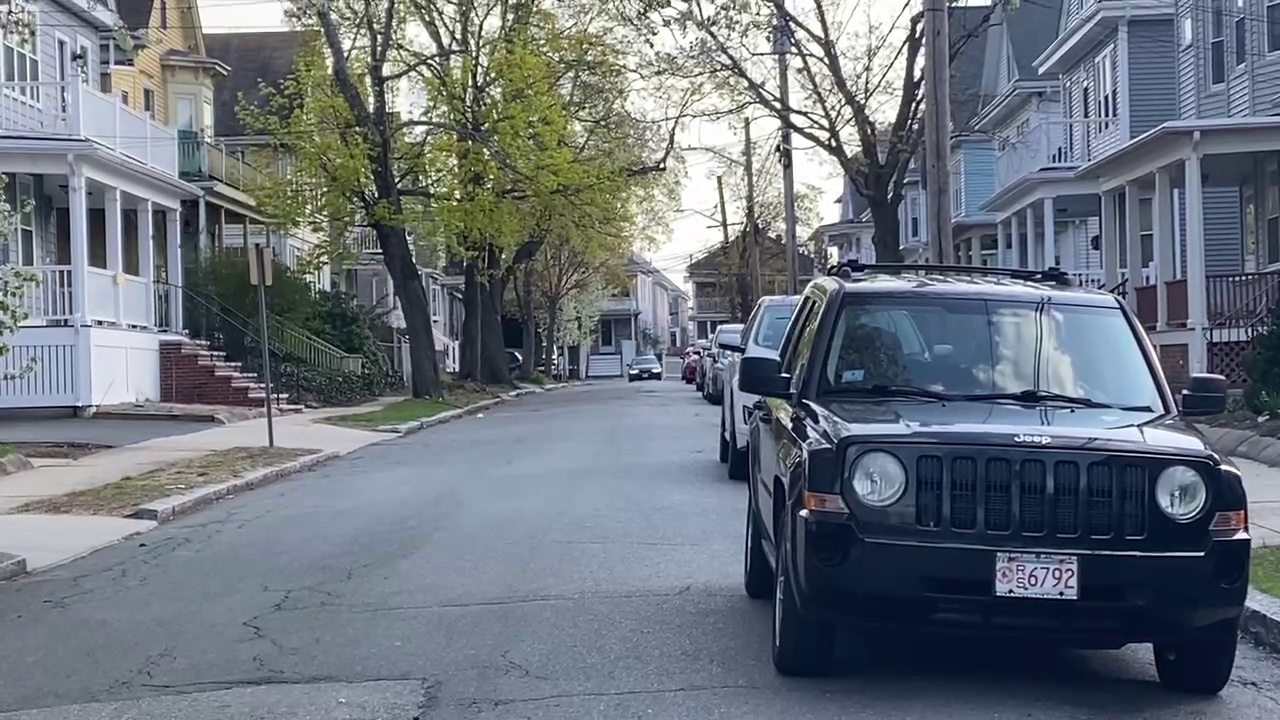

In [5]:
video = cv2.VideoCapture('./data/BMW_320I_2018_black_1.MOV')

display_handle=display(None, display_id=True)
try:
    while True:
        _, frame = video.read()
        _, frame = cv2.imencode('.jpeg', frame)
        display_handle.update(Img(data=frame.tobytes()))
except KeyboardInterrupt:
    pass
finally:
    video.release()

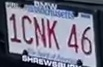

In [6]:
video = cv2.VideoCapture('./data/BMW_320I_2018_black_1.MOV')
# video = cv2.VideoCapture('../data/Honda_Civic_2019_gray_1.MOV')
# assert video.isOpened()  

display_handles = {}
numbers = {}

for object_id, box, plate_image in detection_model.find_boxes_on_video(video, step=5):
    _, image_to_display = cv2.imencode('.jpeg', plate_image)
    numbers.setdefault(object_id, []).append(plate_image)
    if object_id not in display_handles:
        display_handles[object_id] = display(None, display_id=True)    
    display_handles[object_id].update(Img(data=image_to_display.tobytes()))
    

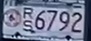

In [7]:
selected_images, best_index = select_best(numbers[0])

display_handle=display(None, display_id=True)
for img in selected_images:
    _, image_to_display = cv2.imencode('.jpeg', img)
    display_handle.update(Img(data=image_to_display.tobytes()))
    time.sleep(0.1)

Stacked image


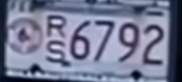

Best from selected


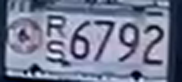

Worst from selected


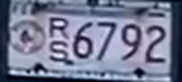

In [8]:
print("Stacked image")
stacked_image, size = stack_images_ECC(selected_images, best_index=best_index)
display(Image.fromarray(cv2.cvtColor(stacked_image, cv2.COLOR_BGR2RGB)))
print("Best from selected")
best_image = cv2.resize(selected_images[best_index], size, interpolation=cv2.INTER_CUBIC)
display(Image.fromarray(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB)))
print("Worst from selected")
best_image_2 = cv2.resize(selected_images[0], size, interpolation=cv2.INTER_CUBIC)
display(Image.fromarray(cv2.cvtColor(best_image_2, cv2.COLOR_BGR2RGB)))

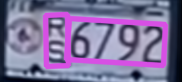

Rotated image:


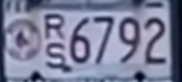

In [9]:
text_boxes_image = stacked_image.copy()
text_detection_model = TextDetectionModel()
perspective_transform = PerspectiveTransform(text_detection_model=text_detection_model)
boxes = text_detection_model.get_text_boxes(stacked_image)

for box in boxes:
    cv2.polylines(text_boxes_image, np.int32([box]),
                  isClosed=True, color=(228, 79, 215), thickness=3,lineType=cv2.LINE_AA)
display(Image.fromarray(cv2.cvtColor(text_boxes_image, cv2.COLOR_BGR2RGB)))

rotated_image = perspective_transform.transform(stacked_image)
print("Rotated image:")
display(Image.fromarray(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB)))

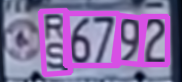

In [10]:
letter_boxes_image = rotated_image.copy()
letter_boxes = text_detection_model.get_letter_boxes(rotated_image)

box_images = []
for box in letter_boxes:    
    box_images.append(cut_box(rotated_image, box))
    cv2.polylines(letter_boxes_image, np.int32([box]),
                  isClosed=True, color=(228, 79, 215), thickness=3, lineType=cv2.LINE_AA)  
display(Image.fromarray(cv2.cvtColor(letter_boxes_image, cv2.COLOR_BGR2RGB)))

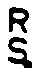

R
S



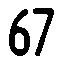

67



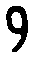

9



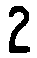

2



'RS6792'

In [11]:
text_result = []
for letter_image in box_images:
    preprocessed_letter_image = letter_image_preprocessing(letter_image)    
    display(Image.fromarray(cv2.cvtColor(preprocessed_letter_image, cv2.COLOR_BGR2RGB)))
    result = pytesseract.image_to_string(preprocessed_letter_image, lang='eng', config='--psm 6 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')
    print(result)
    text_result.append(result.replace("\n", "").strip())
str.join("", text_result)